In [3]:
import pandas as pd
import numpy as np
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
#from math import sqrt
#from matplotlib import pyplot
from numpy import array
import matplotlib.pyplot as plt


C:\Users\ahn\AppData\Local\Temp/ipykernel_4916/1793992048.py:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [4]:
new_water = pd.read_csv('data_tr_apo.csv', encoding='utf-8')
new_water_ts= pd.read_csv('data_ts_apo.csv', encoding='utf-8')

In [6]:
# 결측값 -> 앞뒤 평균으로
new_water=new_water.fillna(new_water.interpolate())

In [7]:
for i in range(0, len(new_water)):
    if (new_water['구미 아포배수지 유출유량 적산차'][i]<0 or new_water['구미 아포배수지 유출유량 적산차'][i]>1350):    # test 데이터 범위 사용
        if (new_water['구미 아포배수지 유출유량 적산차'][i+1]>=0 and new_water['구미 아포배수지 유출유량 적산차'][i+1]<=1350):
            new_water['구미 아포배수지 유출유량 적산차'][i]=(new_water['구미 아포배수지 유출유량 적산차'][i-1]+new_water['구미 아포배수지 유출유량 적산차'][i+1])/2
        else:
            new_water['구미 아포배수지 유출유량 적산차'][i]=(new_water['구미 아포배수지 유출유량 적산차'][i-1]+new_water['구미 아포배수지 유출유량 적산차'][i+2])/2
                
        
    else:
        continue

C:\Users\ahn\AppData\Local\Temp/ipykernel_4916/2598354107.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_water['구미 아포배수지 유출유량 적산차'][i]=(new_water['구미 아포배수지 유출유량 적산차'][i-1]+new_water['구미 아포배수지 유출유량 적산차'][i+2])/2
C:\Users\ahn\AppData\Local\Temp/ipykernel_4916/2598354107.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_water['구미 아포배수지 유출유량 적산차'][i]=(new_water['구미 아포배수지 유출유량 적산차'][i-1]+new_water['구미 아포배수지 유출유량 적산차'][i+1])/2


In [8]:
new_water.set_index('datetime', inplace=True)

In [9]:
new_water_ts.set_index('datetime', inplace=True)

In [10]:
new_water.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35063 entries, 2017-01-01 01:00:00 to 2020-12-31 23:00:00
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   구미 아포배수지 유출유량 적산차  35063 non-null  float64
dtypes: float64(1)
memory usage: 547.9+ KB


In [27]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
# input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
# put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
# drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [28]:
def prepare_data(series, n_lag, n_seq):

    supervised = series_to_supervised(series, n_lag, n_seq)
    # split into train and test sets
    train = supervised.values
    return train

In [13]:
apo_data = pd.concat([new_water,new_water_ts]).reset_index(drop=True)

In [14]:
apo_data

,구미 아포배수지 유출유량 적산차
0,131.0
1,64.0
2,52.0
3,50.0
4,49.0
...,...
43482,112.0
43483,98.0
43484,100.0
43485,96.0


In [15]:
# 데이터 minmax scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
apo_scaler = scaler.fit_transform(apo_data)

In [49]:
len(new_water_ts)

8424

In [50]:
new_water_ts

,구미 아포배수지 유출유량 적산차
datetime,
2021-01-01 00:00:00,67.0
2021-01-01 01:00:00,70.0
2021-01-01 02:00:00,67.0
2021-01-01 03:00:00,59.0
2021-01-01 04:00:00,58.0
...,...
2021-12-17 19:00:00,112.0
2021-12-17 20:00:00,98.0
2021-12-17 21:00:00,100.0


In [29]:
#추가
train1=apo_data[:-(24+len(new_water_ts))]
test1=apo_data[-(24+len(new_water_ts)):]

In [16]:
train1=apo_scaler[:-(24+len(new_water_ts))]
test1=apo_scaler[-(24+len(new_water_ts)):]

In [30]:
n_lag = 24
n_seq = 336

# prepare data
train = prepare_data(train1, n_lag, n_seq)
test = prepare_data(test1, n_lag, n_seq)

In [38]:
X_train=pd.DataFrame(train).T[0:24]

In [39]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,34670,34671,34672,34673,34674,34675,34676,34677,34678,34679
0,131.0,64.0,52.0,50.0,49.0,53.0,59.0,73.0,89.0,102.0,...,4.0,180.0,88.0,163.0,213.0,88.0,84.0,82.0,74.0,70.0
1,64.0,52.0,50.0,49.0,53.0,59.0,73.0,89.0,102.0,102.0,...,180.0,88.0,163.0,213.0,88.0,84.0,82.0,74.0,70.0,58.0
2,52.0,50.0,49.0,53.0,59.0,73.0,89.0,102.0,102.0,89.0,...,88.0,163.0,213.0,88.0,84.0,82.0,74.0,70.0,58.0,58.0
3,50.0,49.0,53.0,59.0,73.0,89.0,102.0,102.0,89.0,127.0,...,163.0,213.0,88.0,84.0,82.0,74.0,70.0,58.0,58.0,56.0
4,49.0,53.0,59.0,73.0,89.0,102.0,102.0,89.0,127.0,170.0,...,213.0,88.0,84.0,82.0,74.0,70.0,58.0,58.0,56.0,53.0
5,53.0,59.0,73.0,89.0,102.0,102.0,89.0,127.0,170.0,161.0,...,88.0,84.0,82.0,74.0,70.0,58.0,58.0,56.0,53.0,55.0
6,59.0,73.0,89.0,102.0,102.0,89.0,127.0,170.0,161.0,127.0,...,84.0,82.0,74.0,70.0,58.0,58.0,56.0,53.0,55.0,62.0
7,73.0,89.0,102.0,102.0,89.0,127.0,170.0,161.0,127.0,84.0,...,82.0,74.0,70.0,58.0,58.0,56.0,53.0,55.0,62.0,188.0
8,89.0,102.0,102.0,89.0,127.0,170.0,161.0,127.0,84.0,90.0,...,74.0,70.0,58.0,58.0,56.0,53.0,55.0,62.0,188.0,178.0
9,102.0,102.0,89.0,127.0,170.0,161.0,127.0,84.0,90.0,91.0,...,70.0,58.0,58.0,56.0,53.0,55.0,62.0,188.0,178.0,104.0


In [40]:
X_test=pd.DataFrame(test).T

In [42]:
X_test11=X_test

In [43]:
k=pd.DataFrame(test1)

In [44]:
k

,구미 아포배수지 유출유량 적산차
35039,65.0
35040,61.0
35041,58.0
35042,56.0
35043,61.0
...,...
43482,112.0
43483,98.0
43484,100.0
43485,96.0


In [45]:
for i in range(8089, 8089+336):
    a=pd.DataFrame(k.loc[i:i+24]).reset_index(drop=True)
    X_test11=pd.concat([X_test11, a], axis=1)

In [46]:
X_test=X_test11[:24]

In [47]:
Y_train=pd.DataFrame(train).T[24:]

In [48]:
Y_train

,0,1,2,3,4,5,6,7,8,9,...,34670,34671,34672,34673,34674,34675,34676,34677,34678,34679
24,102.0,52.0,49.0,49.0,49.0,54.0,67.0,87.0,95.0,101.0,...,99.0,214.0,119.0,100.0,96.0,94.0,83.0,157.0,176.0,66.0
25,52.0,49.0,49.0,49.0,54.0,67.0,87.0,95.0,101.0,104.0,...,214.0,119.0,100.0,96.0,94.0,83.0,157.0,176.0,66.0,67.0
26,49.0,49.0,49.0,54.0,67.0,87.0,95.0,101.0,104.0,95.0,...,119.0,100.0,96.0,94.0,83.0,157.0,176.0,66.0,67.0,60.0
27,49.0,49.0,54.0,67.0,87.0,95.0,101.0,104.0,95.0,152.0,...,100.0,96.0,94.0,83.0,157.0,176.0,66.0,67.0,60.0,57.0
28,49.0,54.0,67.0,87.0,95.0,101.0,104.0,95.0,152.0,163.0,...,96.0,94.0,83.0,157.0,176.0,66.0,67.0,60.0,57.0,59.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,86.0,83.0,86.0,145.0,138.0,104.0,57.0,53.0,54.0,56.0,...,105.0,104.0,127.0,239.0,98.0,99.0,84.0,86.0,102.0,98.0
356,83.0,86.0,145.0,138.0,104.0,57.0,53.0,54.0,56.0,61.0,...,104.0,127.0,239.0,98.0,99.0,84.0,86.0,102.0,98.0,118.0
357,86.0,145.0,138.0,104.0,57.0,53.0,54.0,56.0,61.0,72.0,...,127.0,239.0,98.0,99.0,84.0,86.0,102.0,98.0,118.0,224.0
358,145.0,138.0,104.0,57.0,53.0,54.0,56.0,61.0,72.0,92.0,...,239.0,98.0,99.0,84.0,86.0,102.0,98.0,118.0,224.0,110.0


In [22]:
Y_test=pd.DataFrame(test[1]).T[24:]

In [23]:
X_train=X_train.T
Y_train=Y_train.T

In [24]:
X_test=X_test.T
Y_test=Y_test.T

In [25]:
X_test=X_test.reset_index(drop=True)

In [26]:
X_train=X_train.values


Y_train=Y_train.values

In [27]:
X_test=X_test.values


Y_test=Y_test.values

In [28]:
x_train_t = X_train.reshape(X_train.shape[0],24,1)

In [29]:
x_train_t = X_train.reshape(X_train.shape[0],24,1)

In [30]:
y_train_t = Y_train.reshape(Y_train.shape[0],336,1)

In [31]:
x_test_t = X_test.reshape(X_test.shape[0],24,1)

In [33]:
from keras.layers import LSTM 
from keras.models import Sequential 
from keras.layers import Dense 
import keras.backend as K


K.clear_session() 
# Sequeatial Model
model = Sequential() 
# 첫번째 LSTM 레이어
#model.add(LSTM(60, return_sequences =True, input_shape=(48, 1))) 
model.add(LSTM(60, input_shape=(24, 1))) 
# 두번째 LSTM 레이어
#model.add(LSTM(30,return_sequences=False))  
# 예측값 1개
model.add(Dense(336)) 
# 손실함수 지정 - 예측 값과 실제 값의 차이를 계산한다. MSE가 사용된다. 
# 최적화기 지정 - 일반적으로 adam을 사용한다.
model.compile(loss='mean_squared_error', optimizer='adam') 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60)                14880     
                                                                 
 dense (Dense)               (None, 336)               20496     
                                                                 
Total params: 35,376
Trainable params: 35,376
Non-trainable params: 0
_________________________________________________________________


In [34]:
model.fit(x_train_t, y_train_t, epochs=15,
          batch_size=100)

Epoch 1/15
347/347 [==============================] - 5s 10ms/step - loss: 0.0072
Epoch 2/15
347/347 [==============================] - 5s 14ms/step - loss: 0.0048
Epoch 3/15
347/347 [==============================] - 5s 13ms/step - loss: 0.0040
Epoch 4/15
347/347 [==============================] - 3s 10ms/step - loss: 0.0040
Epoch 5/15
347/347 [==============================] - 3s 10ms/step - loss: 0.0040
Epoch 6/15
347/347 [==============================] - 3s 10ms/step - loss: 0.0039
Epoch 7/15
347/347 [==============================] - 3s 10ms/step - loss: 0.0039
Epoch 8/15
347/347 [==============================] - 3s 10ms/step - loss: 0.0039
Epoch 9/15
347/347 [==============================] - 3s 10ms/step - loss: 0.0039
Epoch 10/15
347/347 [==============================] - 3s 10ms/step - loss: 0.0039
Epoch 11/15
347/347 [==============================] - 3s 10ms/step - loss: 0.0038
Epoch 12/15
347/347 [==============================] - 3s 10ms/step - loss: 0.0038
Epoch 13/15
3

In [35]:
y_pred = model.predict(x_test_t)

264/264 [==============================] - 2s 7ms/step


In [36]:
predict1=scaler.inverse_transform(y_pred)

In [37]:
predict1

array([[ 73.825226,  79.73025 ,  69.389534, ..., 117.69342 , 100.09373 ,
         87.403206],
       [ 71.98298 ,  76.14028 ,  65.71246 , ..., 103.91796 ,  83.38191 ,
         73.06896 ],
       [ 65.87534 ,  63.872963,  58.768955, ...,  88.69583 ,  69.24518 ,
         61.216564],
       ...,
       [ 86.437546,  83.21353 ,  74.23794 , ..., 128.12054 , 113.80816 ,
        101.633675],
       [ 79.99645 ,  76.90397 ,  67.43763 , ..., 119.491936,  99.593666,
         87.02669 ],
       [ 74.167274,  69.09382 ,  60.117012, ..., 105.10506 ,  83.28186 ,
         72.79056 ]], dtype=float32)

def inverse_difference(last_ob, forecast):
    inverted = list()
    inverted.append(forecast[0] + last_ob)
# propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
 
# inverse data transform on forecasts
def inverse_transform(series, forecasts,n_test):
    inverted = list()
    for i in range(0,len(forecasts)):
        # invert differencing
        index = len(series) - n_test + i
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, forecasts[i])
        # store
        inverted.append(inv_diff)
    return inverted

In [ ]:
#tt=inverse_transform(apo_data, predict1, len(predict1))

In [38]:
predict_lstm=pd.DataFrame(predict1)

In [ ]:
predict_lstm.describe()

In [ ]:
predict_data=pd.DataFrame(tt[0])
for i in range(1, len(predict1)):
               predict_data=pd.concat([predict_data, pd.DataFrame(tt[i])], axis=1)

In [ ]:
predict_data=predict_data.T

In [ ]:
predict_data.describe()

In [ ]:
predict_lstm=predict_data

In [39]:
new_water_sample= pd.read_csv('sample_apo.csv', encoding='utf-8')

In [40]:
water_sample=new_water_sample.drop(['datetime'], axis=1)

In [41]:
predict_lstm.columns=list(water_sample.columns)

In [42]:
predict_lstm['datetime'] = new_water_sample['datetime']

In [43]:
predict_lstm.set_index('datetime', inplace=True)

In [44]:
predict_lstm

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h326,h327,h328,h329,h330,h331,h332,h333,h334,h335
datetime,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00,73.825226,79.730247,69.389534,60.121613,54.763969,59.668037,70.778755,90.461983,109.027122,124.082535,...,113.650970,112.204994,107.037811,108.692688,115.716743,128.934311,131.319565,117.693420,100.093727,87.403206
2021-01-01 01:00:00,71.982979,76.140282,65.712463,58.405430,60.761272,72.873306,88.285721,107.266495,120.283035,126.643410,...,110.377823,112.152145,111.540154,116.151405,122.012321,130.250366,123.282990,103.917961,83.381912,73.068962
2021-01-01 02:00:00,65.875343,63.872963,58.768955,61.426292,74.861588,93.382660,108.182663,121.669083,127.873390,127.199242,...,108.371330,115.341728,118.909775,123.512428,123.017197,123.351257,109.031303,88.695831,69.245178,61.216564
2021-01-01 03:00:00,53.333977,47.178143,54.372128,72.622261,96.547638,118.081795,126.776421,131.742142,130.934982,125.850372,...,109.708611,121.669525,126.757774,126.775024,116.215263,108.708427,90.848946,74.151207,58.707001,51.744648
2021-01-01 04:00:00,44.605145,43.932594,66.071236,94.444595,118.962532,136.438065,136.201111,133.467072,127.635368,120.716965,...,117.826111,128.612183,128.177139,119.053596,100.303108,90.162315,73.572174,63.688122,53.456482,48.378616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-17 20:00:00,111.647575,89.530624,80.518990,73.209663,64.456657,59.688984,59.359737,61.226471,77.576973,99.857986,...,128.534882,124.665810,114.174667,110.451485,103.858505,111.012573,121.831535,128.544418,130.198547,129.689178
2021-12-17 21:00:00,96.011879,87.268600,78.555519,70.014793,60.134769,57.734360,61.118343,70.740105,92.145676,115.622742,...,124.010223,119.819183,109.688103,107.787811,106.846786,119.246117,130.300812,131.082901,124.329689,115.925797
2021-12-17 22:00:00,86.437546,83.213531,74.237938,64.314445,56.271797,59.006924,69.466675,86.854973,108.579376,127.592064,...,118.594856,114.144951,105.918968,107.605606,112.964371,127.582222,134.889313,128.120544,113.808159,101.633675


In [45]:
mse_data=new_water_ts

In [46]:
n_lag = 0
n_seq = 336
test_mse = prepare_data(mse_data, n_lag, n_seq)

In [47]:
test_mse1=pd.DataFrame(test_mse)

In [48]:
test_pred=predict_lstm[:8089]

<AxesSubplot:>

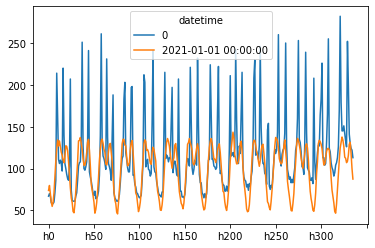

In [52]:
ax1=test_mse1[0:1].T.plot()
test_pred[0:1].T.plot(ax=ax1)

In [49]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(test_pred, test_mse1)

25.57670737096816

In [50]:
predict_lstm.to_csv("sample4_apo.csv", index = True, encoding = 'UTF-8')

In [51]:
#모델 저장
from tensorflow.python.keras.models import load_model
model.save('lstm_multi-step4.h5')

In [ ]:
#모델 불러오기
#from tensorflow.keras.models import load_model
#model = load_model('lstm_multi-step.h5')